# $\textbf{Overview}$
This document provides instructions on running the JWST Science Calibration Pipeline (referred to as “the pipeline”) and individual pipeline steps specifically for <mark>$\textbf{Time Series Observation (TSO) Imaging with NIRCam NRC_TSIMAGE exposure data}$</mark>.

End-to-end calibration of JWST data is divided into 3 main stages of processing. Multiple pipeline modules are used for different stages of processing and for different JWST observing modes. The modules are broken into the following 3 stages:

- $\textbf{Stage 1}$: Detector-level corrections and ramp fitting for individual exposures

- $\textbf{Stage 2}$: Instrument-mode calibrations for individual exposures

- $\textbf{Stage 3}$: Combining data from multiple exposures within an observation

$\textbf{Stage 1}$ corrections are applied nearly universally for all instruments and modes. $\textbf{Stage 2}$ is divided into separate modules for <mark>$\textbf{imaging}$</mark> and spectroscopic modes. $\textbf{Stage 3}$ is divided into five separate modules for imaging, spectroscopic, coronagraphic, Aperture Masking Interferometry (AMI), and <mark>$\textbf{Time Series Observation (TSO)}$</mark> modes.

# $\textbf{Import Library}$ 

In [2]:
import os
#os.environ['CRDS_PATH'] = '/fenrirdata1/kg_data/crds_cache/' #These pathways should be defined in your ~./bash profile. If not, you can set them within the notebook.
#os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
#os.environ['CRDS_CONTEXT']='jwst_0756.pmap' #Occasionally, the JWST CRDS pmap will be updated. Updates may break existing code. Use this command to revert to an older working verison until the issue is fixed. 

import jwst
print(jwst.__version__) #Print what version of the pipeline you are using.

from jwst.pipeline.calwebb_detector1 import Detector1Pipeline #Stage 1
from jwst.pipeline.calwebb_image2 import Image2Pipeline #Stage 2
from jwst.pipeline.calwebb_tso3 import Tso3Pipeline #Stage 3
from jwst.associations.asn_from_list import asn_from_list #Association file imports
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

#General
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
import asdf
import glob
import time
import yaml
from copy import deepcopy


from tshirt.pipeline import phot_pipeline, analysis #tshirt specific imports
from splintegrate import splintegrate

#modeling
import batman
from scipy.optimize import curve_fit

#Style Choice
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

1.3.1


# $\textbf{Stage 1}$
### $\textbf{Detector-level corrections and ramp fitting for individual exposures.}$
Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting.
The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.

#### $\textbf{Detector1Pipeline:}$
Apply all calibration steps to raw JWST ramps to produce a 2-D slope product. This stage takes care of basic data reduction steps, such as reference pixel correction, superbias subtraction, removal of non-linearity, and flagging of cosmic rays. In the final step in this stage of the pipeline, line-fitting is performed on each integration. A slope image is created for each integration. The steps in this stage are identical for all data.

There are two general configurations for this pipeline, depending on whether the data are to be treated as a Time Series Observation (TSO). The configuration is provided by CRDS reference file mappings and are usually set by default to always give access to the most recent reference file deliveries and selection rules. For TSO exposures, <mark>some steps are set to be skipped by default</mark>:

- The <mark>$\textbf{ipc}$</mark> step corrects a JWST exposure for interpixel capacitance by convolving with an IPC reference image.
- The <mark>$\textbf{persistence}$</mark> step. Based on a model, this step computes the number of traps that are expected to have captured or released a charge during an exposure. The released charge is proportional to the persistence signal, and this will be subtracted (group by group) from the science data. 

$\textbf{INPUT FILES:}$
Exposure raw data products are designated by a file name suffix of “uncal.” These files usually contain only the raw detector pixel values from an exposure, with the addition of some table extensions containing various types of meta data associated with the exposure. Additional extensions can be included for certain instruments and readout types. Below are header modifications to the "uncal" fits files. 

In [19]:
#Adding header modifications
all_uncal_files = [] # All Uncalibrated File Names. Also use to check that all files have been modified by the loop. 
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/Raw_Data/'
for fitsName in glob.glob(BaseDirectory + '*nrca3_uncal.fits'): #Grabbing only nrca3 files from the directory
    HDUList = fits.open(fitsName, 'update')
    HDUList[0].header['NOUTPUTS'] = (4, 'Number of output amplifiers') #This was not input at the time of the simulation. Therefore, we manually must input this information. 
    HDUList.close()
    all_uncal_files.append(fitsName)
    
all_uncal_files = sorted(all_uncal_files) #sort files alphabetically. 
#seg01_len=len(glob.glob('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP8/ROEBA/splintegrate/jw01185002001_01101_00001-seg001*.fits'))

In [8]:
startTime = time.time() #Time how long this step takes

for filename_stage1 in all_uncal_files:
    
    # Instantiate the class. Do not provide a configuration file.
    pipeline_stage1 = Detector1Pipeline()
    
    # Manually set any desired non-default parameter values
    
    # Default is to skip the persistence and IPC correction
    # Make that explicit here
    pipeline_stage1.persistence.skip = True
    pipeline_stage1.ipc.skip = True
    
    pipeline_stage1.refpix.skip = False # Make sure to skip steps appropriate if using an alternate ref pix correction method. Otherwise, the default is 'False'.
    pipeline_stage1.superbias.skip = False 
    
    # The default value for CR flagging is 3 or 4 sigma
    # which tends to be too aggressive and flags noise.
    # Set it to something more reasonable
    #pipeline_stage1.jump.rejection_threshold = 9
    pipeline_stage1.jump.skip=True # Currently we are skipping this step as we are testing the pipeline with this simulation and lots of the data gets flagged. 
    
    # Specify that you want results saved to a file
    pipeline_stage1.save_results = True
    pipeline_stage1.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/'
    
    # Execute the pipeline using the run method
    result_stage1 = pipeline_stage1.run(filename_stage1)
    
executionTime = (time.time() - startTime)
print('Stage 1 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2022-03-29 23:32:27,668 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-29 23:32:27,675 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-29 23:32:27,680 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-29 23:32:27,686 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-29 23:32:27,691 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-29 23:32:27,696 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-29 23:32:27,701 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-29 23:32:27,706 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-29 23:32:27,712 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-29 23:32:27,767 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-29 2

2022-03-29 23:33:18,110 - CRDS - INFO -  Fetching  /fenrirdata1/kg_data/crds_cache/mappings/jwst/jwst_0808.pmap      580 bytes  (6 / 6 files) (17.7 K / 18.3 K bytes)
2022-03-29 23:33:19,699 - CRDS - INFO -  Fetching  /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0094.fits   33.6 M bytes  (1 / 1 files) (0 / 33.6 M bytes)
2022-03-29 23:33:22,089 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0262.fits'.
2022-03-29 23:33:22,092 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.
2022-03-29 23:33:22,093 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.
2022-03-29 23:33:22,094 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file 

2022-03-29 23:46:32,231 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(105, 12, 256, 2048) from jw01366002001_01101_00001-seg001_nrca3_uncal.fits>,).
2022-03-29 23:46:32,233 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/Raw_Data'}
2022-03-29 23:46:32,285 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits
2022-03-29 23:46:32,800 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-29 23:46:32,802 - stpipe.Detector1Pi

2022-03-30 00:04:37,980 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2022-03-30 00:04:37,981 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2022-03-30 00:04:37,987 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2022-03-30 00:04:40,644 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg001_nrca3_rateints.fits
2022-03-30 00:04:40,650 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-03-30 00:04:40,855 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg001_nrca3_rate.fits
2022-03-30 00:04:40,856 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2022-03-30 00:04:40,885 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-30 00:04:40,888 - stpipe.Detector1Pipeline.group_scale - INFO - GroupS

2022-03-30 00:04:49,381 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0262.fits'.
2022-03-30 00:04:49,383 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0048.fits'.
2022-03-30 00:04:49,386 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.
2022-03-30 00:04:49,387 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0058.fits'.
2022-03-30 00:04:49,389 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.
2022-03-30 00:04:49,392 - stpipe.Detector1Pipeline - INFO - Prefetch for RE

2022-03-30 00:22:22,697 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits
2022-03-30 00:22:23,201 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:22:23,203 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:22:23,204 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:22:23,206 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:22:23,207 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will 

2022-03-30 00:41:12,168 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg002_nrca3_rateints.fits
2022-03-30 00:41:12,171 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-03-30 00:41:12,349 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg002_nrca3_rate.fits
2022-03-30 00:41:12,351 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2022-03-30 00:41:12,388 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-30 00:41:12,393 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-30 00:41:12,400 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-30 00:41:12,405 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-30 00:41:12,410 - stpipe.Detector1Pipeline.ipc - INFO - IPCSt

2022-03-30 00:41:23,722 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0053.fits'.
2022-03-30 00:41:23,725 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0058.fits'.
2022-03-30 00:41:23,727 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.
2022-03-30 00:41:23,728 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-30 00:41:23,732 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-03-30 00:41:23,734 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2022-03-30 00:41:23,738 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/c

2022-03-30 00:55:23,490 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:55:23,491 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:55:23,492 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:55:23,493 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:55:23,494 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-30 00:55:23,495 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-

2022-03-30 01:10:03,558 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2022-03-30 01:10:03,676 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg003_nrca3_rate.fits
2022-03-30 01:10:03,678 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2022-03-30 01:10:03,701 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-30 01:10:03,704 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-30 01:10:03,707 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-30 01:10:03,710 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-30 01:10:03,713 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-30 01:10:03,716 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-30 01:10:03,720 - stpipe.Detector1Pipeline.refp

2022-03-30 01:10:09,645 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0058.fits'.
2022-03-30 01:10:09,648 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0030.fits'.
2022-03-30 01:10:09,649 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-30 01:10:09,650 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-03-30 01:10:09,652 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2022-03-30 01:10:09,654 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0094.fits'.
2022-03-30 01:10:09,656 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/

2022-03-30 01:23:55,672 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2022-03-30 01:23:55,676 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2022-03-30 01:23:55,856 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(63, 256, 2048) from jw01366002001_01101_00001-seg004_nrca3_uncal.fits>,).
2022-03-30 01:23:55,860 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/Raw_Data'}
2022-03-30 01:23:55,957 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2022-03-30 01:23:55,959 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be ski

Stage 1 Execution Time in Seconds: 6689.657697439194


$\textbf{OUTPUT FILES:}$ Output files are \*rateints.fits. The pipeline creates a rate.fits and a rateint.fits files in cases where there is more than one integration in a file, but only a rate.fits file in the case where there is only one integration in a file.

In [9]:
all_rateints_files = [] # All Rateints File Names. Also used to check that all the rateints file exist.  
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/'
for fitsName in glob.glob(BaseDirectory + '*nrca3_rateints.fits'): #Grabbing only nrca3 files from the directory
    all_rateints_files.append(fitsName)

### $\textbf{Confirming a Source}$
Plotting one of the rateints.fits files to check that a target source is present before moving on to stage 2 and stage 3. 

2022-03-30 12:03:10,144 - stpipe - WARNING - /tmp/ipykernel_1197944/371570451.py:3: ResourceWarning: unclosed file <_io.FileIO name='/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg001_nrca3_rateints.fits' mode='rb' closefd=True>
  HDUList = fits.open(file)



(600.0, 1400.0)

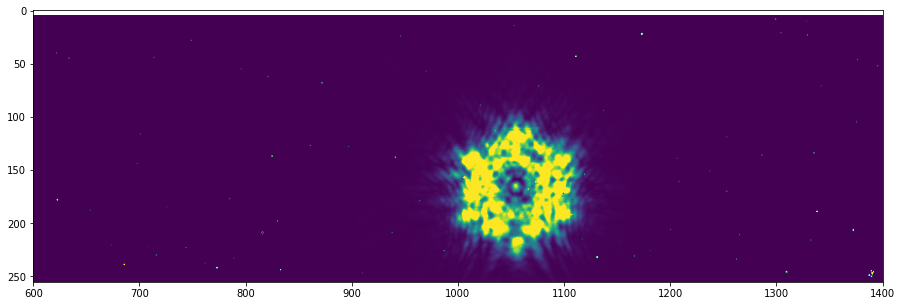

In [16]:
#A check to ensure the star is in the file
file = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/jw01366002001_01101_00001-seg001_nrca3_rateints.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(22,5))
ax.imshow(image2D, vmin=0, vmax=50)
#ax.plot(image2D[32,:])
ax.set_xlim(600,1400)


#### $\textbf{Split the Integrations for tshirt (referenced later)}$

In [17]:
#splitegrate
#Splintegrate splits and combines integrations from the pipeline up.
#Set flipToDet = False to not flip the x-axis
#This is a step required if running tshirt

#This simulation has multiple segments that need to be split for tshirt purposes.
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/'
for rateints_segment in glob.glob(BaseDirectory + '*nrca3_rateints.fits'): #Grabbing only nrca3 files from the directory
    outDir = '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/splintegrate/'
    splint = splintegrate.splint(inFile=rateints_segment,outDir=outDir,flipToDet=False)
    splint.split()

100%|███████████████████████████████████████████| 63/63 [00:01<00:00, 48.31it/s]


# Checking the Centering
After preforming splintegrate, access a file via SAOImageDS9 and confirm the center coordinates. Input this into the tshirt yaml file and plot below. After confirming, move to the ROEBA file for this data. 

In [34]:
#read in yaml parameter file, a file required to run tshirt

with open("/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_NRCA3_phot_pipeline.yaml", "r") as stream:
    paramfile = yaml.safe_load(stream)

paramfile

{'procFiles': '/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/splintegrate/jw01366002001_01101_00001-seg*.fits',
 'excludeList': None,
 'srcName': 'WASP39b_WLP8_NRCA3',
 'srcNameShort': 'NRCA3_WASP39b',
 'nightName': 'NRCA3_WASP39b_2022_07_22',
 'refStarPos': [[1055, 166]],
 'refPhotCentering': None,
 'copyCentroidFile': None,
 'srcGeometry': 'Circular',
 'bkgSub': True,
 'bkgGeometry': 'CircularAnnulus',
 'bkgMethod': 'mean',
 'apRadius': 50,
 'apHeight': None,
 'apWidth': None,
 'backStart': 60,
 'backEnd': 70,
 'backHeight': None,
 'backWidth': None,
 'backOffset': [0.0, 0.0],
 'boxFindSize': 5,
 'jdRef': 2457551,
 'timingMethod': 'JWSTint',
 'scaleAperture': False,
 'apScale': 2.5,
 'apRange': [2, 17],
 'isCube': False,
 'cubePlane': 0,
 'doCentering': True,
 'FITSextension': 0,
 'HEADextension': 0,
 'isSlope': True,
 'subpixelMethod': 'exact',
 'readNoise': 16.2,
 'detectorGain': 2.05,
 'dateFormat': 'Two Part',
 'diagnosticMode': False,
 'bkgOrderX': 0,
 'bkgOrderY': 0,
 'back

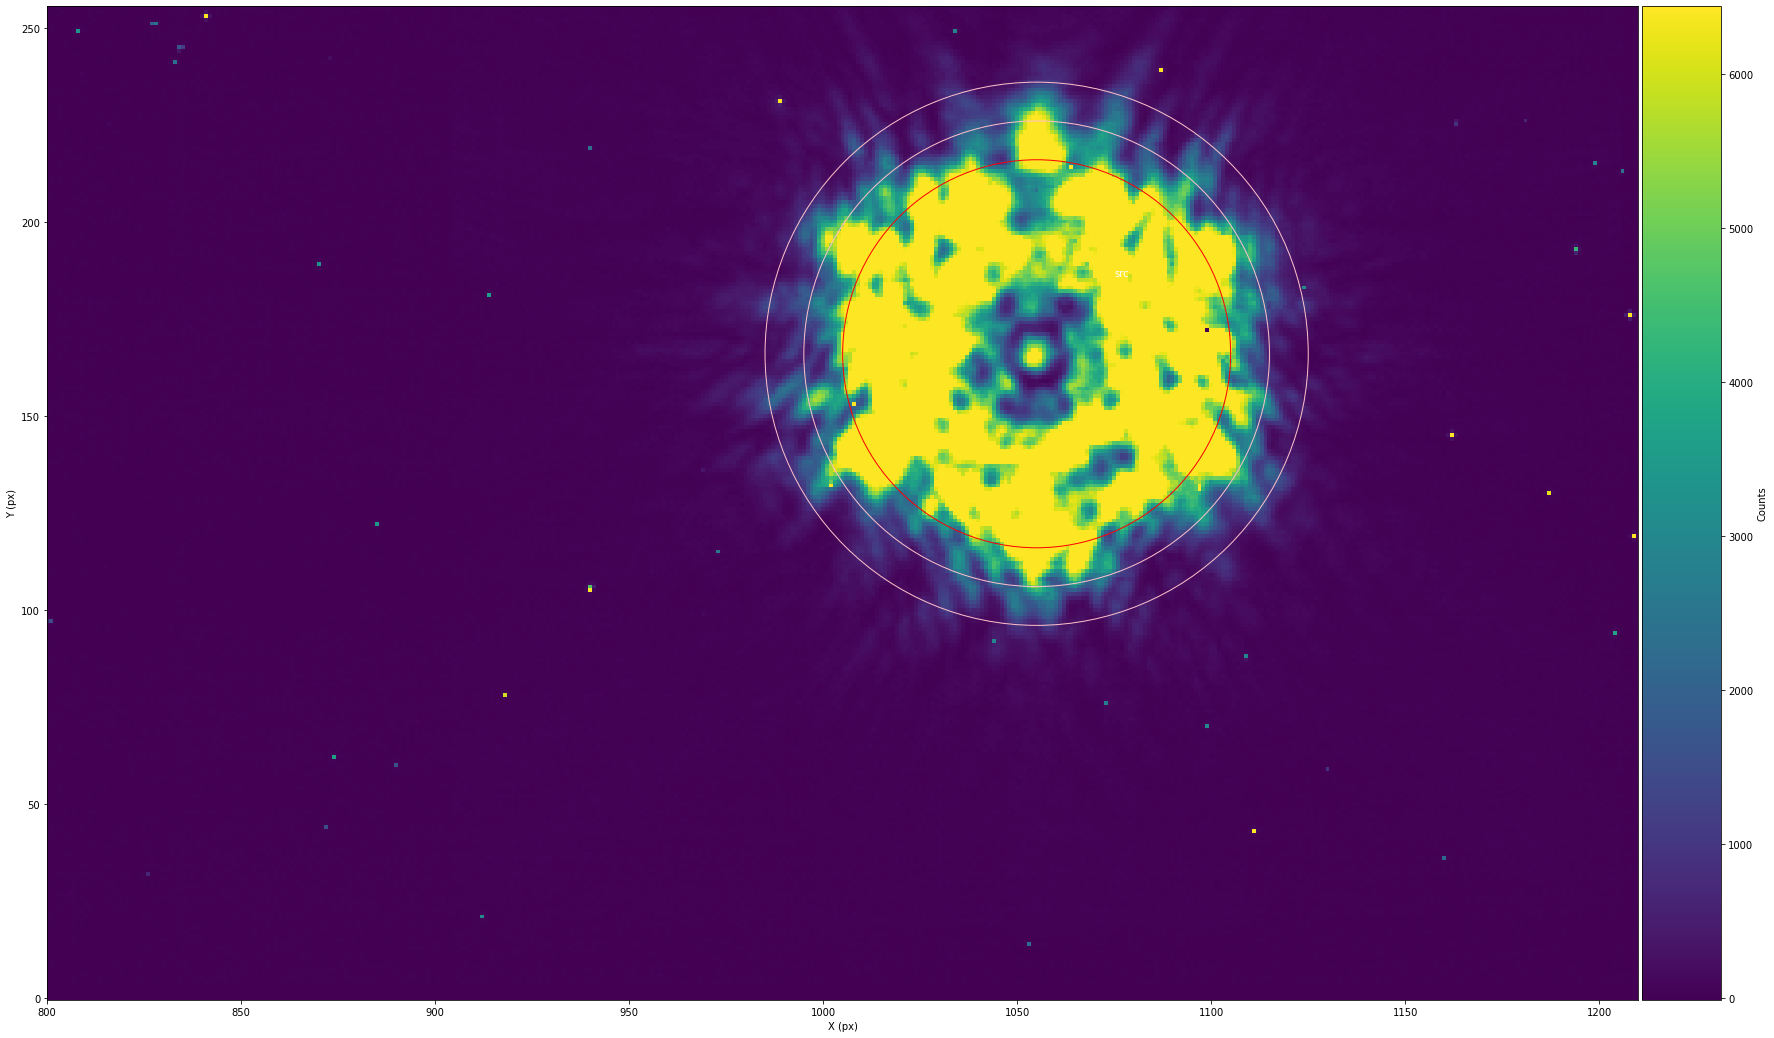

In [36]:
#Assignimg a object phot
phot = phot_pipeline.phot(paramFile="/fenrirdata1/kg_data/pipeline_output/WASP39b_WLP8/WASP39b_WLP8_NRCA3_phot_pipeline.yaml") #create a photometric object
phot.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20), xLim = [800,1210]) #Plot the source and background subtraction area